In [1]:
import matplotlib.pyplot as plt
import json
import numpy as np

from src.data_models.positional.waypoint import Waypoint, Waypoints
from src.data_models.probability_map import ProbabilityMap
from src.waypoint_generation.waypoint_factory import WaypointFactory, WaypointAlgorithmEnum

In [2]:
from src.waypoint_generation import CostFunc
cost_func = CostFunc()

Starting matlab engine...
Matlab engine started as <matlab.engine.matlabengine.MatlabEngine object at 0x7f0c30626fd0>


In [3]:
with open("algorithms_output.json", 'r') as f:
    data = json.loads(json.load(f))
    
img = np.array(data['img'])
del data['img']

for key in WaypointAlgorithmEnum:
    key = str(key)
    try:
        dat = data[key]
        wps = Waypoints(dat['wps'])        
        dat['wps'] = wps
        data[key].update(dat)
        print(f"{key} does exist ({len(wps)} wps)")
    except KeyError:
        print(f"{key} doesn't exist")

data

WaypointAlgorithmEnum.LHC_GW_CONV does exist (120 wps)
WaypointAlgorithmEnum.PARALLEL_SWATHS does exist (23 wps)
WaypointAlgorithmEnum.MODIFIED_LAWNMOWER does exist (25 wps)
WaypointAlgorithmEnum.PABO does exist (16 wps)


{'WaypointAlgorithmEnum.PARALLEL_SWATHS': {'wps': <src.data_models.positional.waypoint.Waypoints at 0x7f0be2defa30>,
  'cost': 1318.6877515989113,
  'time': 0.08972549438476562},
 'WaypointAlgorithmEnum.MODIFIED_LAWNMOWER': {'wps': <src.data_models.positional.waypoint.Waypoints at 0x7f0be2df1460>,
  'cost': 5750.99071724088,
  'time': 464.63234424591064},
 'WaypointAlgorithmEnum.PABO': {'wps': <src.data_models.positional.waypoint.Waypoints at 0x7f0be2df1ee0>,
  'cost': -252.8861048715465,
  'time': 28.57779598236084},
 'WaypointAlgorithmEnum.LHC_GW_CONV': {'wps': <src.data_models.positional.waypoint.Waypoints at 0x7f0be2ddfa00>,
  'cost': 3108.4103606604835,
  'time': 30.03165888786316}}

WaypointAlgorithmEnum.PARALLEL_SWATHS
121.4142 units long
0.0897s


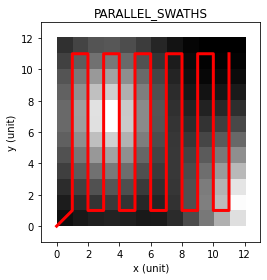

WaypointAlgorithmEnum.MODIFIED_LAWNMOWER
158.4142 units long
464.6323s


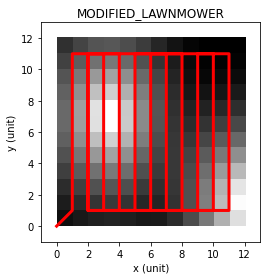

WaypointAlgorithmEnum.PABO
79.9991 units long
28.5778s


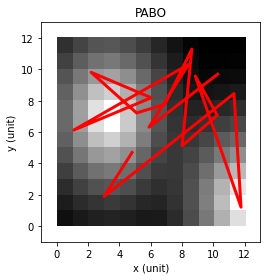

WaypointAlgorithmEnum.LHC_GW_CONV
139.2965 units long
30.0317s


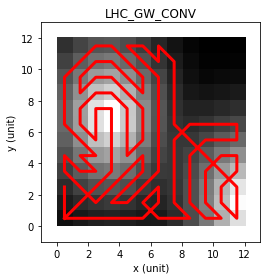

In [4]:
def plot(alg):
    fig, ax = plt.subplots()
    
    ax.imshow(img, interpolation=None,origin='bottom', extent=[0, img.shape[0], 0, img.shape[1]], cmap='gray')
    wps = data[str(alg)]['wps'].toNumpyArray()
    
    dist = np.sum(np.linalg.norm(wps[1:] - wps[:-1],axis=1))
    
    
    
    ax.plot(wps[:,0],wps[:,1],'r',linewidth=3)
        
    ax.set_xlim(-1,img.shape[0]+1)
    ax.set_ylim(-1,img.shape[1]+1)
    ax.set_xlabel("x (unit)")
    ax.set_ylabel("y (unit)")
    
    s = str(alg).split('.')[1]
    fig.savefig(s+"_path.png")
    ax.set_title(s)
    
    return fig,ax,dist
    
    
for key in data.keys():
    fig,ax,dist = plot(key)
    print(f"{key}\n{dist:.4f} units long\n{data[key]['time']:.4f}s")
    plt.tight_layout()
    plt.show()
    data[key]['dist'] = dist

In [5]:
def plot_bar(x,y,x_label,y_label):

    fig,ax = plt.subplots()
    plt.xticks(rotation=45)
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    ax.grid(True, linestyle='--', which='major',
                       color='grey', alpha=.25)
    ax.bar(x,y)   

    return fig,ax

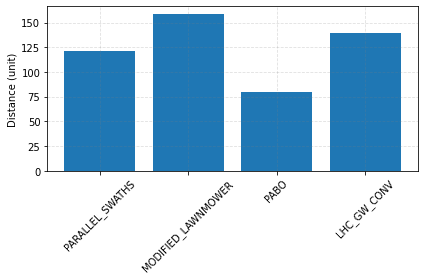

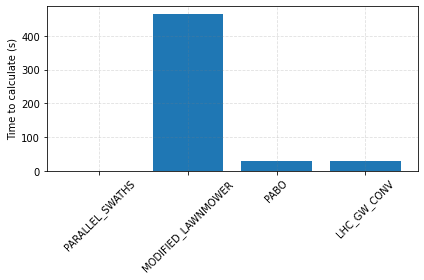

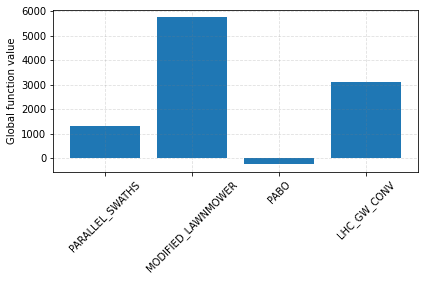

In [6]:
dists = [item[1]['dist'] for item in data.items()]
times = [item[1]['time'] for item in data.items()]
cost = [item[1]['cost'] for item in data.items()]

x = [str(s).split('.')[1] for s in data.keys()]

fig,ax=plot_bar(x,dists,"","Distance (unit)")
plt.tight_layout()
fig.savefig("unit_distances_all.png")

fig,ax=plot_bar(x,times,"","Time to calculate (s)")
plt.tight_layout()
fig.savefig("time_to_calculate_all.png")

fig,ax=plot_bar(x,cost,"","Global function value")
plt.tight_layout()
plt.show()

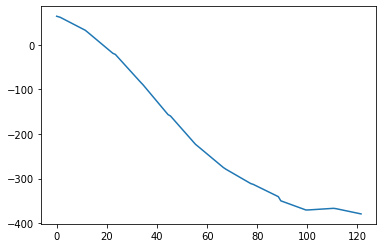

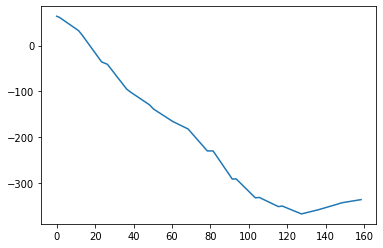

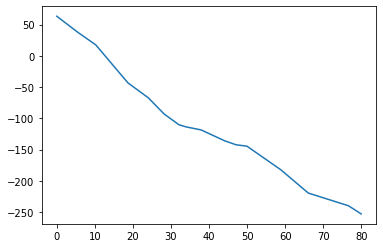

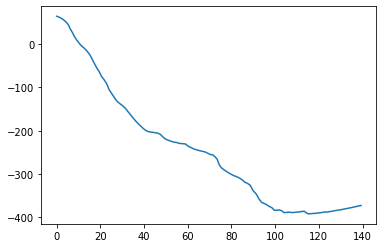

In [7]:
# Cost over distance

for key in data.keys():
    wps = data[key]['wps'].toNumpyArray()
    cost_over_wps = []
    dist_with_wps = np.cumsum([0]+[np.linalg.norm(g-f) for g,f in zip(wps[:-1],wps[1:])])
    for i in range(len(wps)):
        tmp_wps = Waypoints(wps[:i+1])
        cost = cost_func.calculate(tmp_wps,ProbabilityMap(img))
        cost_over_wps.append(cost)
    
    plt.plot(dist_with_wps,cost_over_wps)
    plt.show()

In [8]:
data

{'WaypointAlgorithmEnum.PARALLEL_SWATHS': {'wps': <src.data_models.positional.waypoint.Waypoints at 0x7f0be2defa30>,
  'cost': 1318.6877515989113,
  'time': 0.08972549438476562,
  'dist': 121.41421356237309},
 'WaypointAlgorithmEnum.MODIFIED_LAWNMOWER': {'wps': <src.data_models.positional.waypoint.Waypoints at 0x7f0be2df1460>,
  'cost': 5750.99071724088,
  'time': 464.63234424591064,
  'dist': 158.4142135623731},
 'WaypointAlgorithmEnum.PABO': {'wps': <src.data_models.positional.waypoint.Waypoints at 0x7f0be2df1ee0>,
  'cost': -252.8861048715465,
  'time': 28.57779598236084,
  'dist': 79.99908612713985},
 'WaypointAlgorithmEnum.LHC_GW_CONV': {'wps': <src.data_models.positional.waypoint.Waypoints at 0x7f0be2ddfa00>,
  'cost': 3108.4103606604835,
  'time': 30.03165888786316,
  'dist': 139.29646455628168}}